# Amazon Bin Data
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [3]:
# TODO: Install any packages that you might need
!pip install tqdm
!pip install split-folders
!pip install opencv-python delete
!pip install smdebug
!pip install torch
!pip install torchvision --no-cache-dir

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached split_folders-0.4.3-py3-none-any.whl (7.4 kB)
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is depr

In [4]:
# TODO: Import any packages that you might need
import os
import json
import boto3
import tqdm

import sagemaker

from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)


In [5]:
s3 = boto3.client("s3")
bucket_name = "sagemaker-studio-bsgtzws2phr"
prefix = 'project'
role = sagemaker.get_execution_role()

## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [50]:
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
#         print(v, 'v')
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
#             print(v)
#             break
        for file_path in v: #tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

In [54]:
import splitfolders
splitfolders.ratio('train_data', output="data_split", seed=1337, ratio=(.8, 0.2)) 

Copying files: 10441 files [06:14, 27.91 files/s]


In [23]:
# check the split
dirs = os.listdir('data_split')
print(dirs, 'dirs')

for dirname in dirs:
    pth = os.path.join(root, dirname)
    for rt, dr, fl in os.walk(pth):
        print('2', rt,  dr, fl)
        for d in dr: 
            p =  os.path.join(rt, d)
            print(p)
            print(len(os.listdir(p)))
        break




['test', '.ipynb_checkpoints', 'train'] dirs
2 data_split/test ['4', '2', '1', '5', '3'] []
data_split/test/4
475
data_split/test/2
460
data_split/test/1
246
data_split/test/5
375
data_split/test/3
534
2 data_split/.ipynb_checkpoints [] []
2 data_split/train ['4', '2', '1', '5', '3'] []
data_split/train/4
1898
data_split/train/2
1839
data_split/train/1
982
data_split/train/5
1500
data_split/train/3
2132


In [4]:
# upload to s3
# !aws s3 cp data_split s3://sagemaker-studio-bsgtzws2phr/project/ --recursive

## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [52]:
from PIL import Image
import io

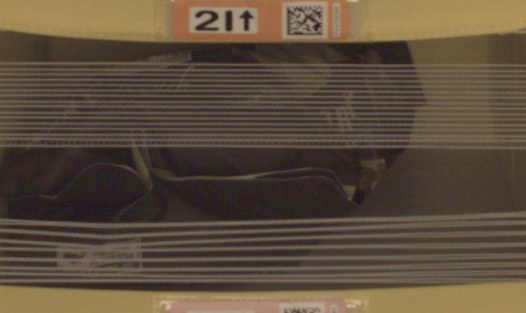

In [54]:
# fetching object from bucket
file_obj = s3.get_object(Bucket=bucket_name, Key='project/train/1/00014.jpg')
# reading the file content in bytes
file_content = file_obj["Body"].read()
Image.open(io.BytesIO(file_content))

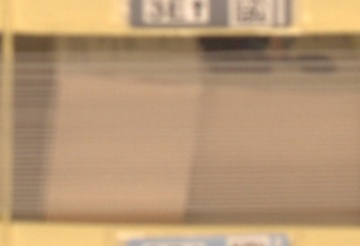

In [55]:
file_obj = s3.get_object(Bucket=bucket_name, Key='project/train/2/00034.jpg')
# reading the file content in bytes
file_content = file_obj["Body"].read()
Image.open(io.BytesIO(file_content))

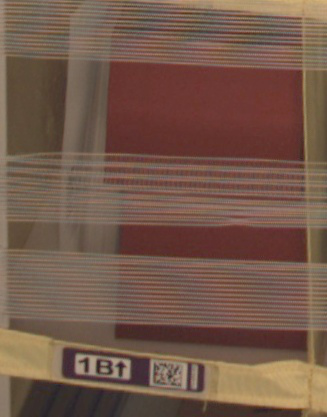

In [56]:
#TODO: Perform any data cleaning or data preprocessing
# s3://sagemaker-studio-bsgtzws2phr/project/train/3/
file_obj = s3.get_object(Bucket=bucket_name, Key='project/train/3/00031.jpg')
# reading the file content in bytes
file_content = file_obj["Body"].read()
Image.open(io.BytesIO(file_content))

All images are different sizes, we will resize them. 

In [57]:
#TODO: Upload the data to AWS S3

Before going to the GPU for training, all image data must have the same dimensions for length, width and channel. Typically, algorithms use a square format so the length and width are the same and many pre-made datasets areadly have the images nicely cropped into squares. However, most real-world datasets will begin with images in many different dimensions and ratios. In order to prep our dataset for training we will need to resize and crop the images if they aren’t already square.

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [5]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([64, 128, 256, 512]),
    "epochs": IntegerParameter(2, 4)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", 
                       "Regex": "average test loss: ([0-9\\.]+)"}]



role = sagemaker.get_execution_role()
estimator = PyTorch(
    entry_point="train.py", #training file with benchmark model
    role=role, #execution role
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large",
    )

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=1,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

In [9]:
os.environ['SM_MODEL_DIR']=f's3://{bucket_name}/{prefix}/model/'
os.environ['SM_OUTPUT_DATA_DIR']= f's3://{bucket_name}/{prefix}/output/'
os.environ["SM_CHANNEL_TRAIN"] = f's3://{bucket_name}/{prefix}/train/'
os.environ["SM_CHANNEL_TEST"] = f's3://{bucket_name}/{prefix}/test/'
os.environ["SM_CHANNEL_TRAINING"] = f's3://{bucket_name}/{prefix}'

In [14]:
tuner.fit({"training": f's3://{bucket_name}/{prefix}/'})

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [15]:
best_estimator = tuner.best_estimator()


2022-01-19 21:24:15 Starting - Preparing the instances for training
2022-01-19 21:24:15 Downloading - Downloading input data
2022-01-19 21:24:15 Training - Training image download completed. Training in progress.
2022-01-19 21:24:15 Uploading - Uploading generated training model
2022-01-19 21:24:15 Completed - Training job completed


In [16]:
#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"64"',
 'epochs': '3',
 'lr': '0.07193579359536591',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-01-19-20-38-21-994"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-401364375837/pytorch-training-2022-01-19-20-38-21-994/source/sourcedir.tar.gz"'}

In [5]:
# {'_tuning_objective_metric': '"average test loss"',
#  'batch_size': '"64"',
#  'epochs': '3',
#  'lr': '0.07193579359536591',
#  'sagemaker_container_log_level': '20',
#  'sagemaker_estimator_class_name': '"PyTorch"',
#  'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
#  'sagemaker_job_name': '"pytorch-training-2022-01-19-20-38-21-994"',
#  'sagemaker_program': '"train.py"',
#  'sagemaker_region': '"us-east-1"',
#  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-401364375837/pytorch-training-2022-01-19-20-38-21-994/source/sourcedir.tar.gz"'}

In [16]:
# hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
#                    "learning_rate": best_estimator.hyperparameters()['lr'],
#                    "epochs": int(best_estimator.hyperparameters()['epochs'])}

hyp = {
    "batch_size" : 64,
    "lr": 0.07193579359536591,
    "epochs": 3
}

# Set up debugging and profiling rules and hooks
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
)

debuggerconfig = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "100",
         "eval.save_interval": "10"}
)

# from sagemakar.debugger import CollectionConfig
# collection_configs=[
#     CollectionConfig(
#         name="tensor_collection",
#         parameters={
#             "train.save_interval": "100",
#             "eval.save_interval": "10"
#         }
#     )
# ]
# debuggerconfig=DebuggerHookConfig(
#     collection_configs=collection_configs
# )

# profiler, already imported Rule and rule_configs
from sagemaker.debugger import ( 
    ProfilerRule, 
)
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

profilerconfig = ProfilerConfig(
    system_monitor_interval_millis=500, 
    framework_profile_params=FrameworkProfile(num_steps=10)
)


rules = [
    # profiler rules
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    # debugger rules
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

In [17]:
# estimator with hyperparameters , profiler and debugger
estimator = PyTorch(
    entry_point="train_debugprof.py",
    base_job_name="bestmodel",
    role= role ,
    instance_count=1,
    instance_type="ml.m5.large",
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=hyp,
    rules=rules,
    debugger_hook_config=debuggerconfig,
    profiler_config=profilerconfig,
    # 
)


estimator.fit({"training": f's3://{bucket_name}/{prefix}/'}, wait=True)

2022-01-22 20:02:25 Starting - Starting the training job...
2022-01-22 20:02:29 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-01-22 20:03:47 Starting - Preparing the instances for training.........
2022-01-22 20:05:17 Downloading - Downloading input data............
2022-01-22 20:07:18 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-22 20:07:19,373 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-22 20:07:19,377 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-01-22 20:07:19,388 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succee

Confusion matrix

In [ ]:
#load daved model
# model = models.resnet18() # we do not specify pretrained=True, i.e. do not load default weights
# model.load_state_dict(torch.load('model_weights.pth'))
# model.eval()


In [18]:
import torchvision
import torch
import torchvision.models as models
import torchvision.transforms as transforms

# use the hyperparams
# def create_data_loaders(hyperparameters):
'''
This is an optional function that you may or may not need to implement
depending on whether you need to use data loaders or not
'''

# this location is not found
# testdir = r"s3://sagemaker-studio-bsgtzws2phr/project/test"
# copied to this url
# testdir ='s3://projectdataevaluation/test/'
testdir = './data_split/test'

testing_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

testset = torchvision.datasets.ImageFolder(
    root=testdir, 
    transform=testing_transform)

testloader = torch.utils.data.DataLoader(
    testset,shuffle=False, batch_size=64)
    



In [23]:
estimator.eval()
# for inputs, labels in test_loader:
#     inputs=inputs.to(device)
#     labels=labels.to(device)
outputs=estimator(inputs)
_, preds = torch.max(outputs, 1)

#     running_loss += loss.item() * inputs.size(0)
#     running_corrects += torch.sum(preds == labels.data).item()

# total_loss = running_loss / len(test_loader.dataset)
# total_acc = running_corrects/ len(test_loader.dataset)
# print(f"Testing Accuracy: {100*total_acc}, average test loss: {total_loss}")


AttributeError: 'PyTorch' object has no attribute 'eval'

In [28]:
estimator.model_data

's3://sagemaker-us-east-1-401364375837/bestmodel-2022-01-22-20-02-25-258/output/model.tar.gz'

In [ ]:
model = sagemaker.model.Model(
    image=image
    model_data='s3://bucket/model.tar.gz',
    role=role_arn)

In [22]:
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
        output = estimator.predict(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = (1, 2,3,4,5)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

AttributeError: 'PyTorch' object has no attribute 'predict'

In [21]:
inputs

tensor([[[[-0.1314, -0.1314, -0.1314,  ...,  0.4508,  0.4679,  0.4851],
          [-0.2684, -0.2684, -0.2342,  ...,  0.1768,  0.1768,  0.2111],
          [-0.4911, -0.5082, -0.4739,  ...,  0.3309,  0.3309,  0.3309],
          ...,
          [ 0.9646,  0.9646,  0.9646,  ...,  1.2557,  1.2728,  1.2899],
          [ 0.9132,  0.9132,  0.9132,  ...,  1.2214,  1.2214,  1.2728],
          [ 0.8618,  0.8618,  0.8618,  ...,  1.2214,  1.2385,  1.2899]],

         [[-0.1975, -0.2150, -0.2325,  ...,  0.3452,  0.3452,  0.3627],
          [-0.3200, -0.3375, -0.3200,  ...,  0.0301,  0.0301,  0.0301],
          [-0.5476, -0.5651, -0.5476,  ..., -0.0399, -0.0224, -0.0049],
          ...,
          [ 0.6429,  0.6604,  0.6604,  ...,  0.9755,  0.9755,  0.9755],
          [ 0.6078,  0.6254,  0.6254,  ...,  0.9055,  0.9055,  0.9230],
          [ 0.5728,  0.5903,  0.5903,  ...,  0.8880,  0.8704,  0.8880]],

         [[-0.2358, -0.2532, -0.2707,  ...,  0.2348,  0.2173,  0.2348],
          [-0.3055, -0.3230, -

In [ ]:
print(classification_report(y_true, y_pred))

In [ ]:
precision_recall_fscore_support(y_true,y_pred )

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [ ]:
#TODO: Create your hyperparameter search space

In [ ]:
#TODO: Create your training estimator

In [ ]:
# TODO: Fit your estimator

In [ ]:
# TODO: Find the best hyperparameters

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [ ]:
# TODO: Deploy your model to an endpoint

In [ ]:
# TODO: Run an prediction on the endpoint

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances